In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

# seed
torch.manual_seed(113)
torch.cuda.manual_seed(113)
np.random.seed(113)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Dataset

In [2]:
train_dir = "train/"
test_dir = "test/"

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(400),
    transforms.CenterCrop(224),
    transforms.RandomRotation(5), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.Resize(400),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_img = datasets.ImageFolder(train_dir, transform=train_transform)
test_img = datasets.ImageFolder(test_dir, transform=test_transform)

# Explore the Data

In [4]:
print("train_img type   :",type(train_img))
print("train_img length :",len(train_img))
print("test_img length :",len(test_img))
print("train_img classes:",train_img.classes)
print("train_img[0] type:",type(train_img[0]))
print("train_img[0][0] t:",type(train_img[0][0]))
print("train_img[0][1] t:",type(train_img[0][1]))
print("train_img[0][0] s:",train_img[0][0].size())
print("train_img[0][1]  :",train_img[0][1])

train_img type   : <class 'torchvision.datasets.folder.ImageFolder'>
train_img length : 940
test_img length : 120
train_img classes: ['JUICE', 'MILK', 'SODA', 'VINEGAR', 'WATER']
train_img[0] type: <class 'tuple'>
train_img[0][0] t: <class 'torch.Tensor'>
train_img[0][1] t: <class 'int'>
train_img[0][0] s: torch.Size([3, 224, 224])
train_img[0][1]  : 0


In [5]:
def imshow(data_image, tensor=False):
    image = data_image[0]
    label = data_image[1]
    image = image.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.show()
    
    print(train_img.classes[label])

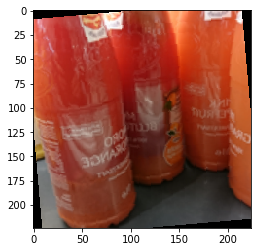

JUICE


In [6]:
imshow(train_img[0])

# Create the Loader

In [7]:
trainloaders = torch.utils.data.DataLoader(train_img, batch_size=44, shuffle=True)
testloaders = torch.utils.data.DataLoader(test_img, batch_size=32, shuffle=True)

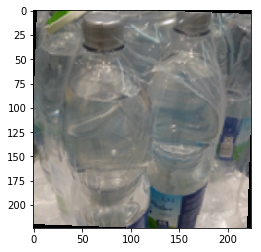

WATER


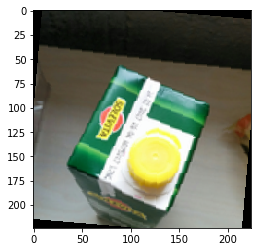

JUICE


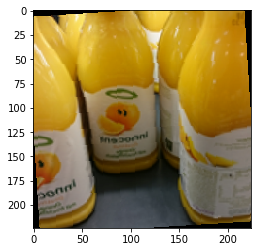

JUICE


In [8]:
for image, label in trainloaders:
    for i in range(3):
        imshow((image[i], label[i]))
    break

# Create the Architecture

In [9]:
import torchvision.models as models

model = models.resnet34(pretrained=True)

for params in model.parameters():
    params.requires_grad_(False)
    
model.fc = torch.nn.Sequential(
                    torch.nn.Linear(512, 64),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(),
                    torch.nn.Linear(64, 5))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epoch = 10

In [11]:
model.train()

for i in range(epoch):
    total_loss = 0
    total_sample = 0    
    total_correct = 0
    
    for image, label in trainloaders:
        image = image.to(device)
        label = label.to(device)
        
        out = model(image)
        
        loss = criterion(out, label)
        total_loss += loss.item()
        total_sample += len(label)
        total_correct += torch.sum(torch.max(out,1)[1]==label).item()*1.0
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("epoch", i, total_loss/total_sample, total_correct/total_sample)

epoch 0 0.03299591351062694 0.4297872340425532
epoch 1 0.02583713119334363 0.5957446808510638
epoch 2 0.0213242714075332 0.675531914893617
epoch 3 0.01882626737685914 0.7031914893617022
epoch 4 0.017196695411458927 0.7393617021276596
epoch 5 0.016130108909404025 0.7648936170212766
epoch 6 0.014910825516315217 0.7787234042553192
epoch 7 0.01409345583078709 0.7925531914893617
epoch 8 0.013148034126200574 0.8202127659574469
epoch 9 0.012627881194682831 0.8287234042553191


In [12]:
model.eval()
total_loss = 0
total_sample = 0    
total_correct = 0

for image, label in testloaders:
    image = image.to(device)
    label = label.to(device)
    
    out = model(image)

    loss = criterion(out, label)
    total_loss += loss.item()
    total_sample += len(label)
    total_correct += torch.sum(torch.max(out, 1)[1] == label).item()*1.0


print("test loss", total_loss/total_sample)
print("test accuracy", total_correct/total_sample)

test loss 0.01702898070216179
test accuracy 0.8


# Sanity Check

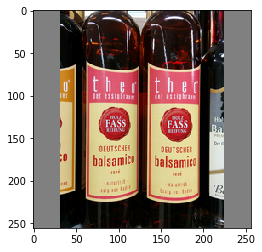

In [13]:
imagepath = "VINEGAR0139.png"
image_test = Image.open(imagepath)
plt.imshow(image_test)
plt.show()

In [14]:
image_transformed = test_transform(image_test) 
image_transformed = image_transformed.unsqueeze(0).to(device)
out = model(image_transformed)
print(out)
print("PREDICTION:", train_img.classes[torch.max(out,1)[1]])

tensor([[ 2.4841, -1.7597, -0.8908,  1.7847, -4.3271]], device='cuda:0',
       grad_fn=<AddmmBackward>)
PREDICTION: JUICE
